## Fit AuotoARIMA

In [1]:
import pandas as pd


# List of file paths
file_paths = ['rnd/2013-7/392.csv', 'rnd/2013-8/392.csv', 'rnd/2013-9/392.csv']

# Initialize an empty list to store each DataFrame
dataframes = []

# Loop through each file path, load the data, and append to the list
for file_path in file_paths:
    df = pd.read_csv(file_path, sep=';\t', engine='python')  # Load each file
    dataframes.append(df)  # Append the DataFrame to the list

# Concatenate all DataFrames in the list into a single DataFrame
data = pd.concat(dataframes, ignore_index=True)

# Adjusting the timestamp to reflect the correct year and month ("2013-08")

# We will recalculate the timestamp considering that each measurement was taken every 5 minutes starting from August 2013
# Assuming the first record starts at the beginning of August 2013
start_date = "2013-07-01 00:00:00"
start_timestamp = pd.to_datetime(start_date)

# Generating timestamps for each row, assuming 5-minute intervals
timestamps = [start_timestamp + pd.Timedelta(minutes=5*i) for i in range(len(data))]

# Assigning the new timestamps to the dataframe
data['ds'] = timestamps


# Creating the two univariate datasets with the corrected timestamp
cpu_usage_dataset_with_corrected_timestamp = data[['ds', 'CPU usage [%]']].copy()
cpu_usage_dataset_with_corrected_timestamp  = cpu_usage_dataset_with_corrected_timestamp.rename(columns={'CPU usage [%]': 'y'})

#Resample to hours
cpu_usage_dataset_with_corrected_timestamp['ds'] = pd.to_datetime(cpu_usage_dataset_with_corrected_timestamp['ds'])
cpu_usage_dataset_with_corrected_timestamp.set_index('ds', inplace=True)
cpu_usage_dataset_with_corrected_timestamp = cpu_usage_dataset_with_corrected_timestamp.resample('H').mean()

cpu_usage_dataset_with_corrected_timestamp = cpu_usage_dataset_with_corrected_timestamp.reset_index()


cpu_usage_dataset_with_corrected_timestamp['unique_id'] = 'VM392'

cpu_usage_dataset_with_corrected_timestamp = cpu_usage_dataset_with_corrected_timestamp.tail(30*24) #Select last 7 days of data to make example faster

# Displaying the first few rows of each corrected dataset to verify
cpu_usage_dataset_with_corrected_timestamp




,ds,y,unique_id
1382,2013-08-27 14:00:00,22.661111,VM392
1383,2013-08-27 15:00:00,18.858333,VM392
1384,2013-08-27 16:00:00,22.151389,VM392
1385,2013-08-27 17:00:00,18.577778,VM392
1386,2013-08-27 18:00:00,20.358333,VM392
...,...,...,...
2097,2013-09-26 09:00:00,13.873611,VM392
2098,2013-09-26 10:00:00,15.306944,VM392
2099,2013-09-26 11:00:00,13.561111,VM392
2100,2013-09-26 12:00:00,14.638889,VM392


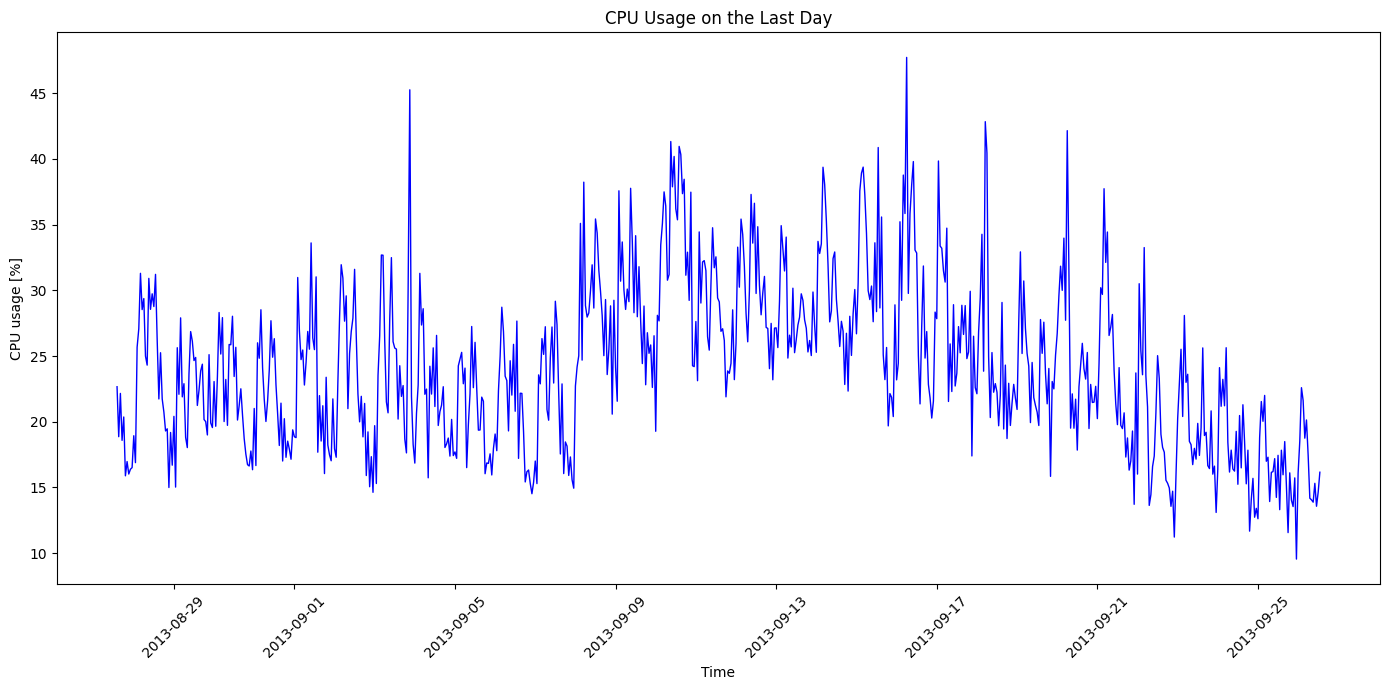

In [2]:
import matplotlib.pyplot as plt

# Plotting the CPU usage data for the last day
plt.figure(figsize=(14, 7))
plt.plot(cpu_usage_dataset_with_corrected_timestamp['ds'], cpu_usage_dataset_with_corrected_timestamp['y'], color='blue', linewidth=1)
plt.title('CPU Usage on the Last Day')
plt.xlabel('Time')
plt.ylabel('CPU usage [%]')
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()

In [3]:
from statsforecast import StatsForecast



/home/simone/.local/lib/python3.8/site-packages/statsforecast/core.py:26: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [4]:
from statsforecast.models import (
    AutoARIMA,
    AutoTheta,
    AutoETS,
    AutoCES,
    MSTL,
    SeasonalNaive,
    WindowAverage,
    SeasonalWindowAverage,
    Naive
)

models = [
    AutoARIMA(season_length=24),
    AutoTheta(season_length=24),
    AutoETS(season_length=24),
    AutoCES(season_length=24),
    MSTL(season_length=24),
    SeasonalNaive(season_length=24), 
    WindowAverage(window_size=24), 
    SeasonalWindowAverage(window_size=1, season_length=24),
    Naive()
]

sf = StatsForecast( 
    models=models,
    freq='H', 
    n_jobs=-1,
)

#forecasts_df = sf.forecast(df=cpu_usage_dataset_with_corrected_timestamp, h=48, level=[90])
#forecasts_df

In [5]:
#sf.plot(cpu_usage_dataset_with_corrected_timestamp,forecasts_df)


In [6]:
crossvaldation_df = sf.cross_validation(
    df=cpu_usage_dataset_with_corrected_timestamp,
    h=168,
    step_size=48,
    n_windows=1
)

/home/simone/.local/lib/python3.8/site-packages/statsforecast/core.py:417: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(


In [7]:
crossvaldation_df

,ds,cutoff,y,AutoARIMA,AutoTheta,AutoETS,CES,MSTL,SeasonalNaive,WindowAverage,SeasWA,Naive
unique_id,,,,,,,,,,,,
VM392,2013-09-19 14:00:00,2013-09-19 13:00:00,27.776388,21.549162,18.584656,21.779154,17.830814,18.649290,22.027779,23.50345,22.027779,19.709723
VM392,2013-09-19 15:00:00,2013-09-19 13:00:00,25.204166,23.645998,19.249981,22.901592,18.972937,22.451859,29.076389,23.50345,29.076389,19.709723
VM392,2013-09-19 16:00:00,2013-09-19 13:00:00,27.575001,22.181973,19.009008,22.096512,18.045115,19.712152,19.445139,23.50345,19.445139,19.709723
VM392,2013-09-19 17:00:00,2013-09-19 13:00:00,23.680555,23.638021,18.206409,21.285633,17.235409,18.916235,24.306944,23.50345,24.306944,19.709723
VM392,2013-09-19 18:00:00,2013-09-19 13:00:00,21.361111,21.720200,16.724258,19.479937,15.096487,17.904610,18.718056,23.50345,18.718056,19.709723
...,...,...,...,...,...,...,...,...,...,...,...,...
VM392,2013-09-26 09:00:00,2013-09-19 13:00:00,13.873611,21.140106,22.996365,24.903023,20.132967,22.088995,24.508333,23.50345,24.508333,19.709723
VM392,2013-09-26 10:00:00,2013-09-19 13:00:00,15.306945,21.026812,24.142153,26.157551,21.625219,22.842218,21.830555,23.50345,21.830555,19.709723
VM392,2013-09-26 11:00:00,2013-09-19 13:00:00,13.561111,21.022951,22.964205,24.554871,20.094282,21.507748,21.234722,23.50345,21.234722,19.709723


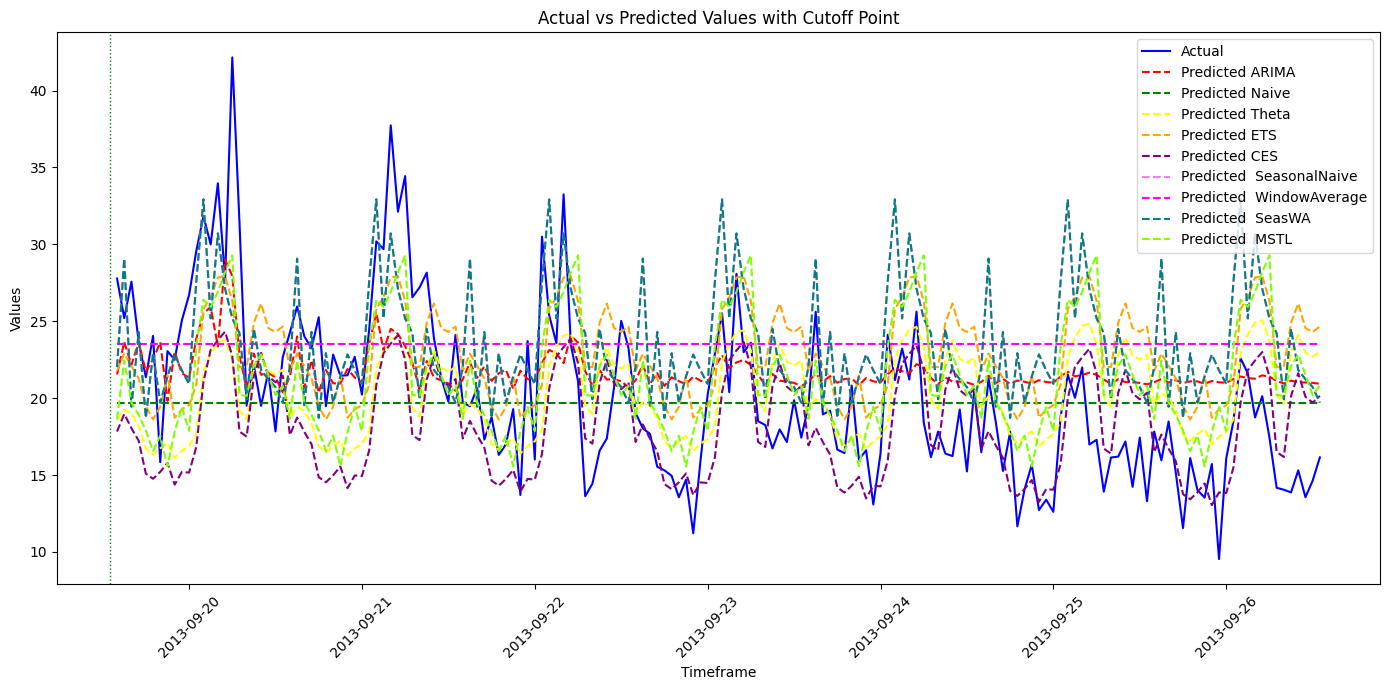

In [8]:
import matplotlib.pyplot as plt
import pandas as pd

# Assuming 'df' is your DataFrame
# Plot the actual and predicted values
plt.figure(figsize=(14, 7))

# Plot actual values
plt.plot(crossvaldation_df['ds'], crossvaldation_df['y'], label='Actual', color='blue')

# Plot predicted values
plt.plot(crossvaldation_df['ds'], crossvaldation_df['AutoARIMA'], label='Predicted ARIMA', color='red', linestyle='--')

plt.plot(crossvaldation_df['ds'], crossvaldation_df['Naive'], label='Predicted Naive', color='green', linestyle='--')

plt.plot(crossvaldation_df['ds'], crossvaldation_df['AutoTheta'], label='Predicted Theta', color='yellow', linestyle='--')

plt.plot(crossvaldation_df['ds'], crossvaldation_df['AutoETS'], label='Predicted ETS', color='orange', linestyle='--')

plt.plot(crossvaldation_df['ds'], crossvaldation_df['CES'], label='Predicted CES', color='purple', linestyle='--')

plt.plot(crossvaldation_df['ds'], crossvaldation_df['SeasonalNaive'], label='Predicted  SeasonalNaive', color='violet', linestyle='--')

plt.plot(crossvaldation_df['ds'], crossvaldation_df['WindowAverage'], label='Predicted  WindowAverage', color='magenta', linestyle='--')

plt.plot(crossvaldation_df['ds'], crossvaldation_df['SeasWA'], label='Predicted  SeasWA', color='teal', linestyle='--')

plt.plot(crossvaldation_df['ds'], crossvaldation_df['MSTL'], label='Predicted  MSTL', color='chartreuse', linestyle='--')

for cutoff in crossvaldation_df['cutoff'].unique():
    plt.axvline(x=cutoff, color='green', linestyle=':', linewidth=1)

plt.title('Actual vs Predicted Values with Cutoff Point')
plt.xlabel('Timeframe')
plt.ylabel('Values')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



In [9]:
from prophet import Prophet
from prophet.diagnostics import performance_metrics
from prophet.diagnostics import cross_validation
from prophet.plot import plot_cross_validation_metric

# Initialize and fit the Prophet model
model = Prophet()

model.fit(cpu_usage_dataset_with_corrected_timestamp)

Importing plotly failed. Interactive plots will not work.
18:05:08 - cmdstanpy - INFO - Chain [1] start processing
18:05:09 - cmdstanpy - INFO - Chain [1] done processing


In [31]:
df['date'] = cpu_usage_dataset_with_corrected_timestamp['ds'].dt.date
tot_num_days = df['date'].nunique()
horizon = 7
initial = tot_num_days - horizon - 2
prophet_horizon = str(horizon) + ' days'
prophet_initial = str(initial) + ' days'
cpu_usage_dataset_with_corrected_timestamp['ds'].dt.date

1382    2013-08-27
1383    2013-08-27
1384    2013-08-27
1385    2013-08-27
1386    2013-08-27
           ...    
2097    2013-09-26
2098    2013-09-26
2099    2013-09-26
2100    2013-09-26
2101    2013-09-26
Name: ds, Length: 720, dtype: object

In [26]:
df_cv = cross_validation(model, horizon=prophet_horizon, initial=prophet_initial)

  0%|          | 0/1 [00:00<?, ?it/s]

18:19:30 - cmdstanpy - INFO - Chain [1] start processing
18:19:30 - cmdstanpy - INFO - Chain [1] done processing


In [12]:
pd.set_option('display.max_rows', 97)
df_cv = df_cv.sort_values(by='ds')
df_cv

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2013-09-19 14:00:00,22.874214,18.035063,27.760208,27.776389,2013-09-19 13:00:00
1,2013-09-19 15:00:00,22.378936,17.480361,27.063686,25.204167,2013-09-19 13:00:00
2,2013-09-19 16:00:00,21.846682,17.061990,26.655787,27.575000,2013-09-19 13:00:00
3,2013-09-19 17:00:00,20.833944,16.464691,25.491150,23.680556,2013-09-19 13:00:00
4,2013-09-19 18:00:00,19.590834,14.763109,24.282233,21.361111,2013-09-19 13:00:00
...,...,...,...,...,...,...
163,2013-09-26 09:00:00,16.514741,10.596771,22.089873,13.873611,2013-09-19 13:00:00
164,2013-09-26 10:00:00,18.077831,12.892043,23.730776,15.306944,2013-09-19 13:00:00
165,2013-09-26 11:00:00,18.410617,12.704323,24.133188,13.561111,2013-09-19 13:00:00
166,2013-09-26 12:00:00,17.376527,11.652286,22.741377,14.638889,2013-09-19 13:00:00


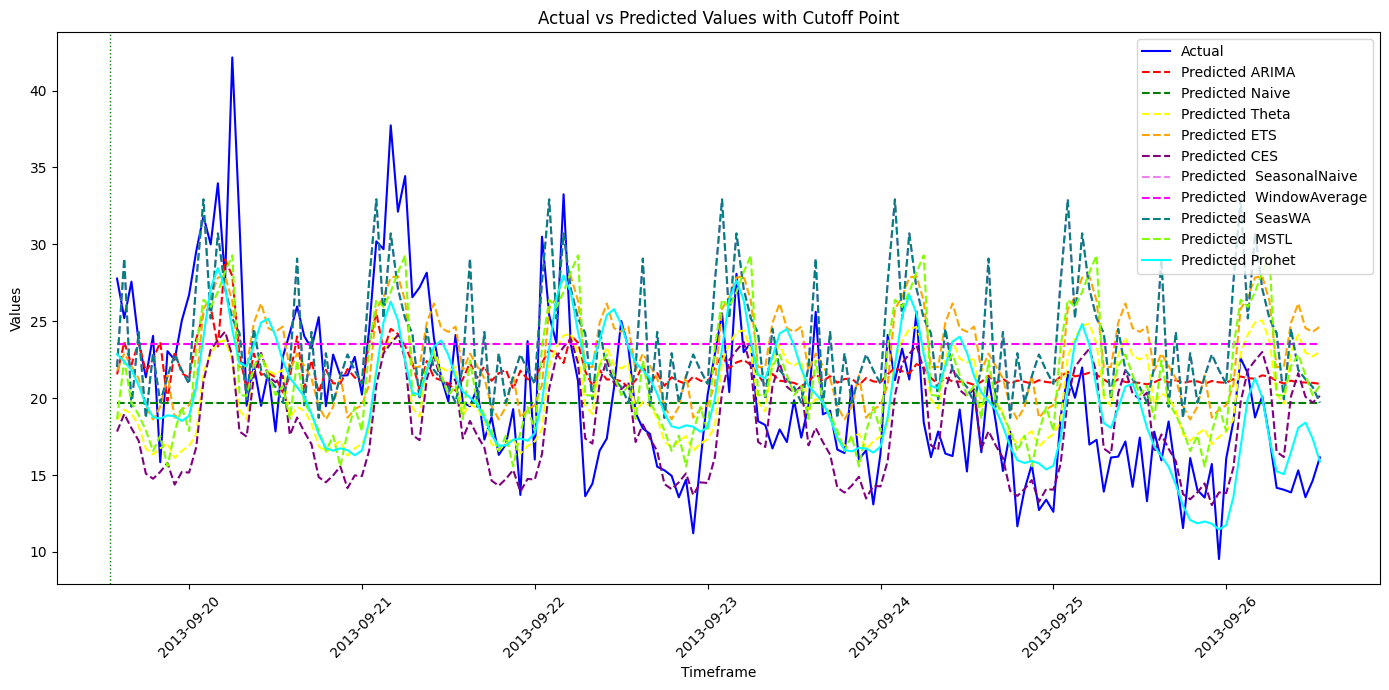

In [13]:
import matplotlib.pyplot as plt
import pandas as pd

# Assuming 'df' is your DataFrame
# Plot the actual and predicted values
plt.figure(figsize=(14, 7))

# Plot actual values
plt.plot(crossvaldation_df['ds'], crossvaldation_df['y'], label='Actual', color='blue')

# Plot predicted values
plt.plot(crossvaldation_df['ds'], crossvaldation_df['AutoARIMA'], label='Predicted ARIMA', color='red', linestyle='--')

plt.plot(crossvaldation_df['ds'], crossvaldation_df['Naive'], label='Predicted Naive', color='green', linestyle='--')

plt.plot(crossvaldation_df['ds'], crossvaldation_df['AutoTheta'], label='Predicted Theta', color='yellow', linestyle='--')

plt.plot(crossvaldation_df['ds'], crossvaldation_df['AutoETS'], label='Predicted ETS', color='orange', linestyle='--')

plt.plot(crossvaldation_df['ds'], crossvaldation_df['CES'], label='Predicted CES', color='purple', linestyle='--')

plt.plot(crossvaldation_df['ds'], crossvaldation_df['SeasonalNaive'], label='Predicted  SeasonalNaive', color='violet', linestyle='--')

plt.plot(crossvaldation_df['ds'], crossvaldation_df['WindowAverage'], label='Predicted  WindowAverage', color='magenta', linestyle='--')

plt.plot(crossvaldation_df['ds'], crossvaldation_df['SeasWA'], label='Predicted  SeasWA', color='teal', linestyle='--')

plt.plot(crossvaldation_df['ds'], crossvaldation_df['MSTL'], label='Predicted  MSTL', color='chartreuse', linestyle='--')

plt.plot(df_cv['ds'], df_cv['yhat'], label='Predicted Prohet', color='cyan', linestyle='-')


for cutoff in crossvaldation_df['cutoff'].unique():
    plt.axvline(x=cutoff, color='green', linestyle=':', linewidth=1)

plt.title('Actual vs Predicted Values with Cutoff Point')
plt.xlabel('Timeframe')
plt.ylabel('Values')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



In [14]:
crossvaldation_df = crossvaldation_df.reset_index()
crossvaldation_df['prophet'] = df_cv['yhat']
crossvaldation_df

,unique_id,ds,cutoff,y,AutoARIMA,AutoTheta,AutoETS,CES,MSTL,SeasonalNaive,WindowAverage,SeasWA,Naive,prophet
0,VM392,2013-09-19 14:00:00,2013-09-19 13:00:00,27.776388,21.549162,18.584656,21.779154,17.830814,18.649290,22.027779,23.50345,22.027779,19.709723,22.874214
1,VM392,2013-09-19 15:00:00,2013-09-19 13:00:00,25.204166,23.645998,19.249981,22.901592,18.972937,22.451859,29.076389,23.50345,29.076389,19.709723,22.378936
2,VM392,2013-09-19 16:00:00,2013-09-19 13:00:00,27.575001,22.181973,19.009008,22.096512,18.045115,19.712152,19.445139,23.50345,19.445139,19.709723,21.846682
3,VM392,2013-09-19 17:00:00,2013-09-19 13:00:00,23.680555,23.638021,18.206409,21.285633,17.235409,18.916235,24.306944,23.50345,24.306944,19.709723,20.833944
4,VM392,2013-09-19 18:00:00,2013-09-19 13:00:00,21.361111,21.720200,16.724258,19.479937,15.096487,17.904610,18.718056,23.50345,18.718056,19.709723,19.590834
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
163,VM392,2013-09-26 09:00:00,2013-09-19 13:00:00,13.873611,21.140106,22.996365,24.903023,20.132967,22.088995,24.508333,23.50345,24.508333,19.709723,16.514741
164,VM392,2013-09-26 10:00:00,2013-09-19 13:00:00,15.306945,21.026812,24.142153,26.157551,21.625219,22.842218,21.830555,23.50345,21.830555,19.709723,18.077831
165,VM392,2013-09-26 11:00:00,2013-09-19 13:00:00,13.561111,21.022951,22.964205,24.554871,20.094282,21.507748,21.234722,23.50345,21.234722,19.709723,18.410617
166,VM392,2013-09-26 12:00:00,2013-09-19 13:00:00,14.638889,21.000107,22.709208,24.312223,19.714138,20.199709,20.725000,23.50345,20.725000,19.709723,17.376527


In [15]:
from utilsforecast.losses import mse
from utilsforecast.evaluation import evaluate

def evaluate_cross_validation(df, metric):
    models = df.drop(columns=['unique_id', 'ds', 'cutoff', 'y']).columns.tolist()
    evals = []
    # Calculate loss for every unique_id and cutoff.    
    for cutoff in df['cutoff'].unique():
        eval_ = evaluate(df[df['cutoff'] == cutoff], metrics=[metric], models=models)
        evals.append(eval_)
    evals = pd.concat(evals)
    evals = evals.groupby('unique_id').mean(numeric_only=True) # Averages the error metrics for all cutoffs for every combination of model and unique_id
    evals['best_model'] = evals.idxmin(axis=1)
    return evals


In [16]:
evaluation_df = evaluate_cross_validation(crossvaldation_df, mse)
evaluation_df.head()

,AutoARIMA,AutoTheta,AutoETS,CES,MSTL,SeasonalNaive,WindowAverage,SeasWA,Naive,prophet,best_model
unique_id,,,,,,,,,,,
VM392,25.229626,29.248936,32.939217,28.434422,24.880816,36.63868,40.999928,36.63868,30.319551,21.016478,prophet
